## Data Exploration / Cleaning

In [21]:
import pandas as pd

# ============================
# 1. Load datasets
# ============================
train_df = pd.read_csv("/Users/riadanas/Desktop/housing regression MLE/data/raw/train.csv")
eval_df = pd.read_csv("/Users/riadanas/Desktop/housing regression MLE/data/raw/eval.csv")
metros = pd.read_csv("/Users/riadanas/Desktop/housing regression MLE/data/raw/usmetros.csv")

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows

In [22]:
print(train_df.shape)
print(eval_df.shape)

(585244, 39)
(149424, 39)


In [23]:
train_df['city_full'].value_counts().head()

city_full
New York-Newark-Jersey City       78020
Chicago-Naperville-Elgin          35344
Los Angeles-Long Beach-Anaheim    33840
Philadelphia-Camden-Wilmington    31396
DC_Metro                          29516
Name: count, dtype: int64

### Map cities to Lat/Long
- The goal is to use Lattitude and longitude instead of cities for our ML models

In [24]:
# ============================
# 2. Fix city name mismatches
# ============================
city_mapping = {
    'Las Vegas-Henderson-Paradise': 'Las Vegas-Henderson-North Las Vegas',
    'Denver-Aurora-Lakewood': 'Denver-Aurora-Centennial',
    'Houston-The Woodlands-Sugar Land': 'Houston-Pasadena-The Woodlands',
    'Austin-Round Rock-Georgetown': 'Austin-Round Rock-San Marcos',
    'Miami-Fort Lauderdale-Pompano Beach': 'Miami-Fort Lauderdale-West Palm Beach',
    'San Francisco-Oakland-Berkeley': 'San Francisco-Oakland-Fremont',
    'DC_Metro': 'Washington-Arlington-Alexandria',
    'Atlanta-Sandy Springs-Alpharetta': 'Atlanta-Sandy Springs-Roswell'
}

In [25]:
def clean_and_merge(df: pd.DataFrame) -> pd.DataFrame:
    """Apply city name fixes, merge lat/lng from metros, drop dup col."""
    df["city_full"] = df["city_full"].replace(city_mapping)
    
    df = df.merge(
        metros[["metro_full", "lat", "lng"]],
        how="left",
        left_on="city_full",
        right_on="metro_full"
    )
    df.drop(columns=["metro_full"], inplace=True)

    # Log any cities that still didn’t match
    missing = df[df["lat"].isnull()]["city_full"].unique()
    if len(missing) > 0:
        print("⚠️ Still missing lat/lng for:", missing)
    else:
        print("✅ All cities matched with metros dataset.")

    return df


In [26]:
# ============================
# 3. Apply cleaning + merge to both train and eval
# ============================
train_df = clean_and_merge(train_df)
eval_df = clean_and_merge(eval_df)

✅ All cities matched with metros dataset.
✅ All cities matched with metros dataset.


In [27]:
print(train_df.shape)
print(eval_df.shape)

(585244, 41)
(149424, 41)


In [28]:
train_df.head(1)

,date,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,median_dom,avg_sale_to_list,sold_above_list,off_market_in_two_weeks,city,zipcode,year,bank,bus,hospital,mall,park,restaurant,school,station,supermarket,Total Population,Median Age,Per Capita Income,Total Families Below Poverty,Total Housing Units,Median Rent,Median Home Value,Total Labor Force,Unemployed Population,Total School Age Population,Total School Enrollment,Median Commute Time,price,city_full,lat,lng
0,2012-03-31,46550.0,217450.0,31.813674,110.183666,14.0,23.0,44.0,64.0,59.5,0.943662,0.142857,0.043478,ATL,30002,2012,12.0,2.0,4.0,1.0,60.0,45.0,57.0,4.0,7.0,5811.0,36.3,33052.0,5811.0,2677.0,710.0,279500.0,3171.0,460.0,5408.0,5408.0,2492.0,200773.999557,Atlanta-Sandy Springs-Roswell,33.7338,-84.3922


In [29]:
# ============================
# 4. Save cleaned datasets
# ============================
train_df.to_csv("/Users/riadanas/Desktop/housing regression MLE/data/processed/cleaning_train.csv", index=False)
eval_df.to_csv("/Users/riadanas/Desktop/housing regression MLE/data/processed/cleaning_eval.csv", index=False)

print("✅ Cleaning complete.")

✅ Cleaning complete.


## Housing prices exploration

In [30]:
df = train_df

/var/folders/1h/14p077t95lbcy6x5tc6bqx3h0000gn/T/ipykernel_91146/1748330476.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


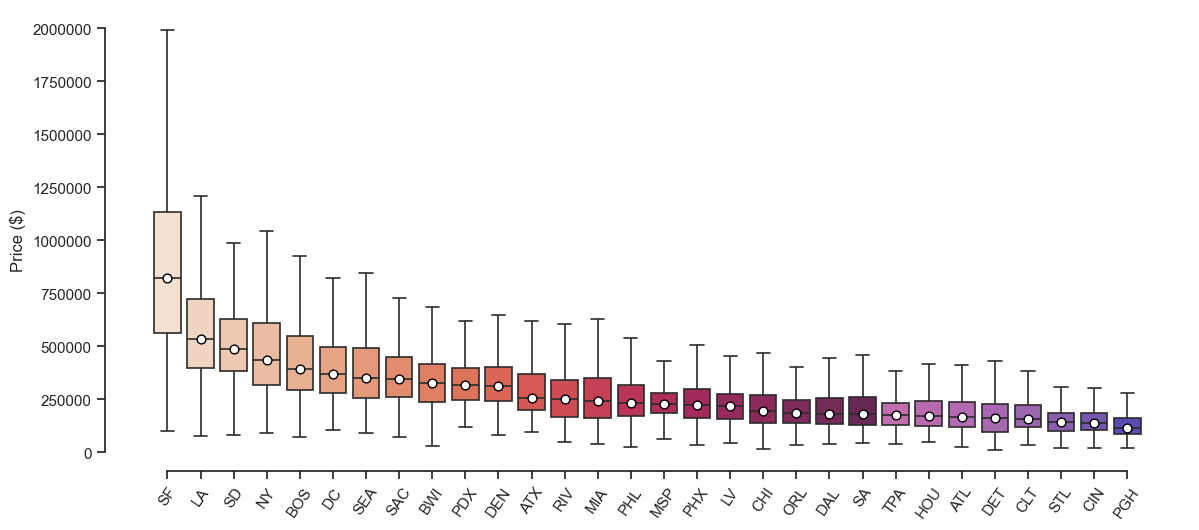

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import colorsys
sns.set_theme(style="whitegrid")           

# Boxplot of house prices for the cities, ordered by median price.

top_cities = df["city"].value_counts().head(30).index.tolist()
df_city    = df[df["city"].isin(top_cities)]
city_order = (
    df_city.groupby("city")["price"]
           .median()
           .sort_values(ascending=False)
           .index
)

base = sns.color_palette("rocket_r", len(city_order))

def lighten(color, amt=.4):
    h, l, s = colorsys.rgb_to_hls(*color)
    return colorsys.hls_to_rgb(h, min(1, l + amt*(1-l)), s)

palette = [
    lighten(c, .45) if i >= len(base) - 8 else c
    for i, c in enumerate(base)
]

sns.set_theme(style="ticks")
fig, ax = plt.subplots(figsize=(14, 6))

sns.boxplot(
    x="city", y="price", data=df_city,
    order=city_order, palette=palette,
    showfliers=False, linewidth=1.2, ax=ax
)

medians = df_city.groupby("city")["price"].median().loc[city_order]
for tick, median in enumerate(medians):
    ax.scatter(tick, median, color="white", edgecolor="black", zorder=5, s=40)

ax.set_xlabel("")
ax.set_ylabel("Price ($)")
ax.tick_params(axis="x", rotation=55)
sns.despine(trim=True)
ax.grid(False)
ax.ticklabel_format(axis="y", style="plain")

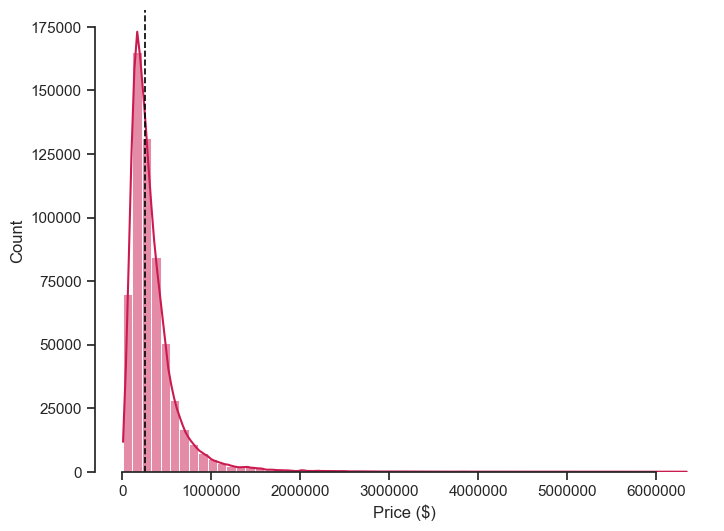

In [32]:
# Distribution of house prices across the dataset 

sns.set_theme(style="ticks")
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(df["price"].dropna(), bins=60, kde=True, color=sns.color_palette("rocket_r", 1)[0], ax=ax)
median_price = df["price"].median()
ax.axvline(median_price, ls="--", lw=1.2, color="black")
ax.set_xlabel("Price ($)")
ax.set_ylabel("Count")
sns.despine(trim=True)
ax.grid(False)
ax.ticklabel_format(axis="x", style="plain")
plt.show()